In [46]:
include("../LiPoSID.jl")

using LinearAlgebra

using DynamicPolynomials

using SymPy

using Plots

function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end


function sympy_to_dynamicpoly(sympy_expr::Sym) #
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end

bˣ = [1, 0, 0, 1]

function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    function SumCoeffs2(poly, s)
        p = SymPy.expand(poly)
        rest_poly = SymPy.subs(p, s => 0)
        degrees = range(1,convert(Int32,SymPy.degree(p, s)))
        obj = sum(p.coeff(s^i)^2 for i in degrees) + rest_poly^2

        return obj
    end   

    @syms s

    Gˢʸᵐᵇ = inv(I(4)*s - Aˢʸᵐᵇ)*b

    Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*b

    ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])

    polys = SymPy.numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys, s))

    #objective = sympy_to_dynamicpoly(obj.subs(s,0))

    return obj

end

TF_objective (generic function with 1 method)

In [43]:
ω = SymPy.symbols("ω", real=true)
γ = SymPy.symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2

Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)

γ2ₜₛₜ = 1 #4π/2
ωₜₛₜ = 25

Aˢⁱᵈ = [  0    -ωₜₛₜ   0      0 
          ωₜₛₜ -γ2ₜₛₜ   0      0
          0     0     -γ2ₜₛₜ   γ2ₜₛₜ
          0     0      0      0    ]

4×4 Matrix{Int64}:
  0  -25   0  0
 25   -1   0  0
  0    0  -1  1
  0    0   0  0

In [47]:
TF_objective(Aᴸᴹᴱ, Aˢⁱᵈ, bˣ)

                      2                      2                                
      4   ⎛     2    ⎞          ⎛ 2         ⎞                      2          
0.25⋅γ  + ⎝1.0⋅γ  - 1⎠  + 625.0⋅⎝γ  + 0.04⋅ω⎠  + 625.0⋅(0.04⋅ω + 1)  + 97656.2

                                2                                   2         
  ⎛          4    2           2⎞             ⎛      4         2    ⎞          
5⋅⎝- 0.0008⋅γ  + γ  - 0.0032⋅ω ⎠  + 390625.0⋅⎝0.01⋅γ  + 0.04⋅ω  + ω⎠  + 390625

                                            2
   ⎛          4           2           2    ⎞ 
.0⋅⎝- 0.0004⋅γ  - 0.0008⋅γ  - 0.0016⋅ω  + 1⎠ 

In [44]:
@syms s

Gˢʸᵐᵇ = inv(I(4)*s - Aᴸᴹᴱ)*bˣ

Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*bˣ

ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])

polys = SymPy.numerator.(ΔG)

3-element Vector{Sym{PyCall.PyObject}}:
 -(s + 1)*(1.0*s^2 + 1.0*s*γ^2 + 0.25*γ^4 + 1.0*ω^2) + (1.0*s + 0.5*γ^2)*(s^2 + s + 625)
                    25.0*s^2 + 25.0*s*γ^2 + 6.25*γ^4 + 25.0*ω^2 - 1.0*ω*(-s^2 - s - 625)
                                                              -s + 1.0*γ^2*(s + 1) - γ^2

In [38]:
poly = polys[1]
poly_str = string(SymPy.expand(poly))
poly_terms = split(poly_str, ['+', '-'])

9-element Vector{SubString{String}}:
 ""
 "0.5*s^2*γ^2 "
 " 0.25*s*γ^4 "
 " 0.5*s*γ^2 "
 " 1.0*s*ω^2 "
 " 625.0*s "
 " 0.25*γ^4 "
 " 312.5*γ^2 "
 " 1.0*ω^2"

In [40]:
function sum_of_squares_of_coeffs(poly, var)
    # Expand the polynomial to simplify it
    expanded_poly = expand(poly)

    # Extract the terms
    terms = Poly(expanded_poly, var).as_expr()

    # Initialize the sum of squares
    sum_of_squares = 0

    # Square the coefficients of each term and add them to the sum
    for term in terms
        coeff, _ = term.as_coeff_Monomial()
        sum_of_squares += coeff^2
    end

    return sum_of_squares
end

sum_of_squares_of_coeffs (generic function with 1 method)

In [41]:
sum_of_squares_of_coeffs(poly, s)

UndefVarError: UndefVarError: `Poly` not defined

In [37]:
coeffs_dict = Dict()

for term_str in poly_terms
    term = Sym(term_str)
    coeff, monom = term.as_coeff_Monomial()
    power = monom.as_coeff_exponent(var)[2]

    # Add the coefficient to the dictionary
    coeffs_dict[power] = get(coeffs_dict, power, 0) + coeff
end

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/zah/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('no symbols given')
  File "/home/zah/anaconda3/lib/python3.11/site-packages/sympy/core/symbol.py", line 727, in symbols
    raise ValueError('no symbols given')


In [28]:
polys[1].coeff(s^0)

⎛             2⎞ ⎛ 2          ⎞
⎝1.0⋅s + 0.5⋅γ ⎠⋅⎝s  + s + 625⎠

In [25]:
polys[1]

#obj = TF_objective(Aᴸᴹᴱ, Aˢⁱᵈ, bˣ)

#best_solution, best_method = LiPoSID.sos_min_newton(objective) 

#objective = sympy_to_dynamicpoly(obj)



MethodError: MethodError: objects of type Nothing are not callable

In [1]:
using SymPy
@syms x y

# Define a polynomial expression
expr = x^2 + 3x*y + y^2 + x

# Collect terms with respect to x
collected_expr = SymPy.collect(expr, x)


 2                  2
x  + x⋅(3⋅y + 1) + y 

In [12]:
collected_expr.coeff(2)

0

In [3]:
sum(collected_expr.coeff(x^i)^2 for i in range(0,2))

                                    2    
         2   ⎛ 2                  2⎞     
(3⋅y + 1)  + ⎝x  + x⋅(3⋅y + 1) + y ⎠  + 1

In [49]:
variables(objective)

3-element Vector{PolyVar{true}}:
 s
 γ
 ω

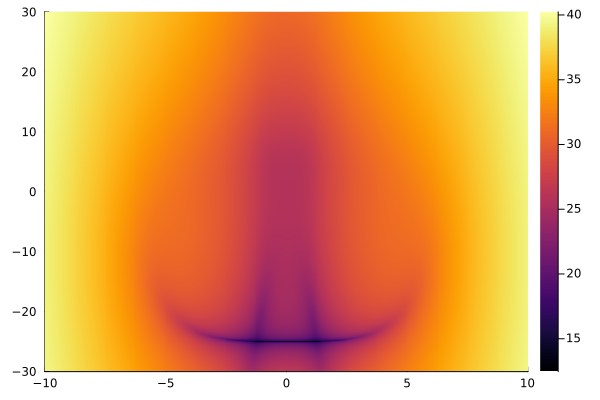

In [35]:
function f(γ_val, ω_val)
    return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
end

w = range(-30, 30, length=1000)
#g = range(-3*γᶠ, 3*γᶠ, length=500)
g = range(-10, 10, length=500)
z = @. f(g', w)

heatmap(g, w, log.(z))

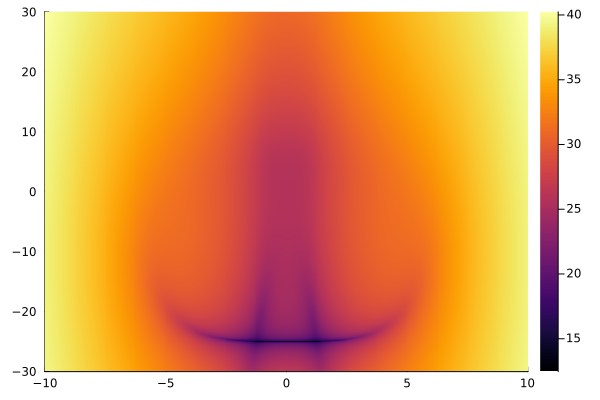

In [36]:
function f(γ_val, ω_val)
    return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
end

w = range(-30, 30, length=1000)
#g = range(-3*γᶠ, 3*γᶠ, length=500)
g = range(-10, 10, length=500)
z = @. f(g', w)

heatmap(g, w, log.(z))

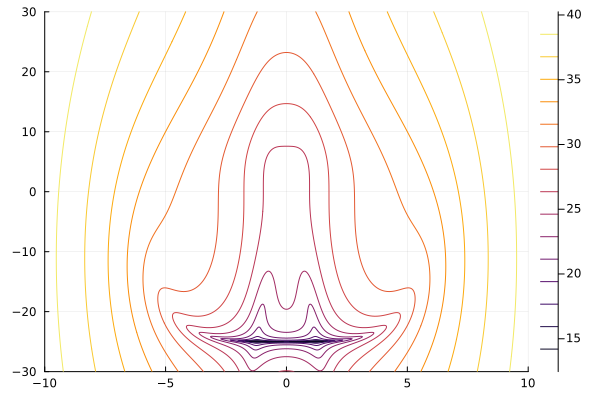

In [37]:
contour(g, w, log.(z))

In [38]:
best_solution, best_method = LiPoSID.sos_min_newton(objective) 

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: SLOW_PROGRESS
solution status: UNKNOWN_RESULT_STATUS
optimum = 80438.37308004318
Found a locally optimal solution by Ipopt, giving an upper bound: 79653.11953735.
The relative optimality gap is: 0.985842%.
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: INFEASIBLE
solution status: NO_SOLUTION
optimum = -4.092418029782172
Found a locally optimal solution by Ipopt, giving an upper bound: 79653.12078857.
The relative optimality gap is: 100.005138%.
No higher TS step of the TSSOS hierarchy!
val_p = [79653.12142944336, 79653.12161254883]


(PolyVar{true}[γ, ω] => [1.2034866831923712, -24.97656815124564], "tssos")

In [39]:
best_solution, best_method = LiPoSID.sos_min_newton(objective) 

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: SLOW_PROGRESS
solution status: UNKNOWN_RESULT_STATUS
optimum = 80438.37308004318
Found a locally optimal solution by Ipopt, giving an upper bound: 79653.11920166.
The relative optimality gap is: 0.985842%.
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: INFEASIBLE


solution status: NO_SOLUTION
optimum = -4.092418029782172
Found a locally optimal solution by Ipopt, giving an upper bound: 79653.12185669.
The relative optimality gap is: 100.005138%.
No higher TS step of the TSSOS hierarchy!
val_p = [79653.11892700195, 79653.12072753906]


(PolyVar{true}[γ, ω] => [-1.2034866807306686, -24.976568151347067], "tssos")